# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [95]:
!pip install tensorflow[and-cuda] numpy==1.25.2 -q

In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.17.1


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [2]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg                                                                 # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                                       # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                                 # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [4]:
# Importing Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Loading Images and Labels
images = np.load('/content/drive/MyDrive/Python - Google Colab/6. Computer Vision/Computer Vision Project - HelmNet/images_proj.npy')
labels = pd.read_csv('/content/drive/MyDrive/Python - Google Colab/6. Computer Vision/Computer Vision Project - HelmNet/Labels_proj.csv')

In [6]:
# Identifying the shape of Image data loaded and labels loaded
print(images.shape)
print(labels.shape)

(631, 200, 200, 3)
(631, 1)


**Observation**: We have loaded the Image dataset and their respective labels. We have 631 Images and Labels with image size 200 x 200 pixels having 3 channels.

# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

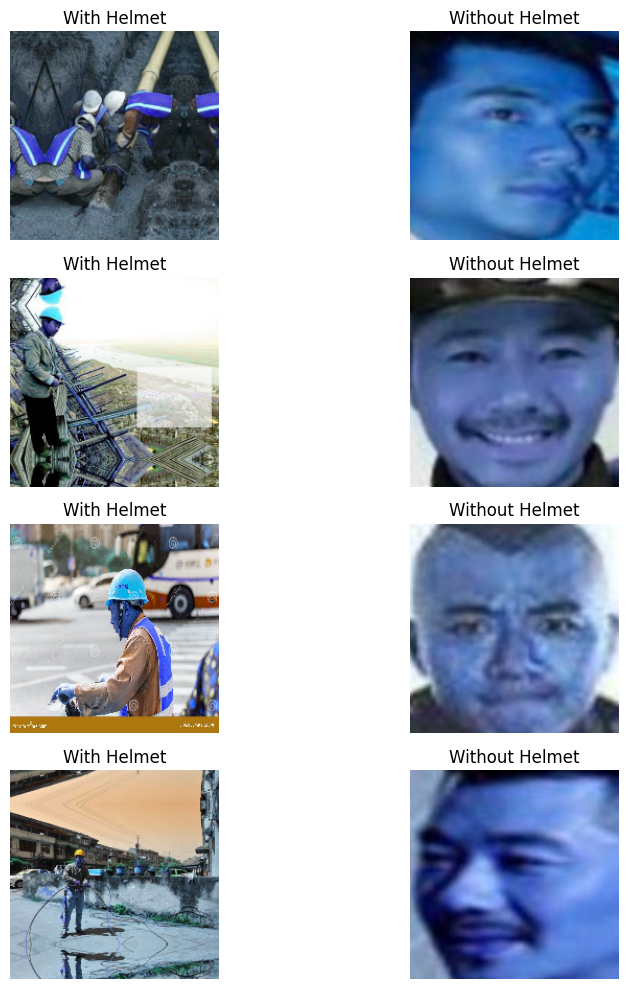

In [7]:
# Finding the labels for 'Images with helmet' and 'Images without helmet'
helmet_img_labels = np.where(labels == 1)[0]
without_helmet_img_labels = np.where(labels == 0)[0]

# Creating a 4x2 grid subplot
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

# Getting 4 random indices for images with helmets (label=1)
random_helmet_indices = np.random.choice(helmet_img_labels, size=4, replace=False)

# Getting 4 random indices for images without helmets (label=0)
random_without_helmet_indices = np.random.choice(without_helmet_img_labels, size=4, replace=False)

# Plotting images in the subplots
for i in range(4):
    # Plotting helmet image in the first column
    axs[i, 0].imshow(images[random_helmet_indices[i]])
    axs[i, 0].set_title('With Helmet')
    axs[i, 0].axis('off') # Hide axes

    # Plotting without helmet image in the second column
    axs[i, 1].imshow(images[random_without_helmet_indices[i]])
    axs[i, 1].set_title('Without Helmet')
    axs[i, 1].axis('off') # Hide axes

plt.tight_layout()              # Adjust layout to prevent titles overlapping
plt.show()                      # Displaying the subplot

**Onservation**: As we can see, the images are getting dispayed with accurate labels.

## Checking for class imbalance


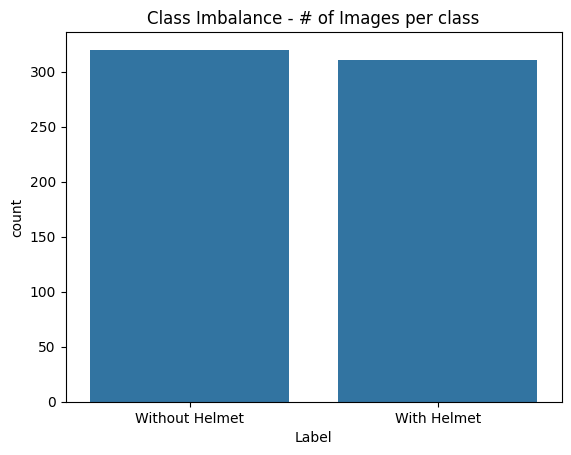

In [8]:
# Plotting a countplot of 2 the classes - 'With helmet' and 'Without Helmet'
sns.countplot(x=labels['Label'])                        # Countplot to segregate based on label value of 0 and 1
plt.title('Class Imbalance - # of Images per class')    # Providing the title of the plot
plt.xticks(ticks=[0, 1], labels=["Without Helmet", "With Helmet"])  # Rename x-axis labels to 'With helmet' and 'Without Helmet' instead of 1 and 0
plt.show()

In [9]:
count_image_with_helmet = labels[labels['Label']==1].shape[0]        # Determining count of images with helmet
count_image_without_helmet = labels[labels['Label']==0].shape[0]     # Determining count of images without helmet
print(f'Number of images with helmet: {count_image_with_helmet}')    # Printing count of images with helmet
print(f'Number of images without helmet: {count_image_without_helmet}')   # Printing count of images without helmet

Number of images with helmet: 311
Number of images without helmet: 320


**Observation**: Hence, as we observe from the countplot and actual count, there is almost no class imbalance in the data provided as there are almost similar count of images from both the classes.
*   311 images with helmet
*   320 images without helmet



# **Data Preprocessing**

## Converting images to grayscale

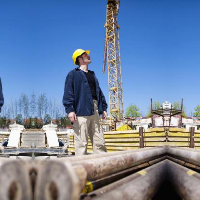

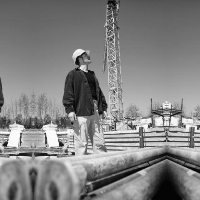

In [10]:
img_gray = np.zeros((images.shape[0], images.shape[1], images.shape[2]), dtype=np.uint8) # Defining an empty np array to add grayscale images

for i in range(len(images)):
  img_gray[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)  # Converting all images to greyscale images and adding it to array defined above.

n = 200                               # Defining an index to randomly select an image between 0 to 630
cv2_imshow(images[n])                 # Displaying the original nth image
cv2_imshow(img_gray[n])               # Displaying the grayscale version of the nth image

In [11]:
img_gray.shape            # Displaying the shape of the array to verify if all of the grayscale images have been added to the array.

(631, 200, 200)

**Obsevation**: We can see the colured image has been converted to Grayscale image and also the array 'img_gray' has all 631 grayscale equivalent images.

### Splitting the dataset



Since we have a very small dataset of 631 images, we will use majority i.e., 80% of them for training and 10% each for validation and testing and stratify the labels so that we have similar representation of both classes across train, val and test datasets.

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42, stratify = labels)  # Splitting the entire data to 80% in training set and 20% as temp data. X: Images, Y: Labels
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify = y_temp)      # Splitting the temp data to 50% Validation set and 50% Test set i.e., 10% each of overall dataset
print(f"X_train shape: {X_train.shape}", f"y_train shape: {y_train.shape}")       # Printing the shape of train data
print(f"X_val shape: {X_val.shape}", f"y_val shape: {y_val.shape}")               # Printing the shape of validation data
print(f"X_test shape: {X_test.shape}", f"y_test shape: {y_test.shape}")           # Printing the shape of test data

X_train shape: (504, 200, 200, 3) y_train shape: (504, 1)
X_val shape: (63, 200, 200, 3) y_val shape: (63, 1)
X_test shape: (64, 200, 200, 3) y_test shape: (64, 1)


In [13]:
# Using value_counts checking the spread of the labels (0, 1) across training, validation and test data
print(y_train['Label'].value_counts())
print(y_val['Label'].value_counts())
print(y_test['Label'].value_counts())

Label
0    256
1    248
Name: count, dtype: int64
Label
0    32
1    31
Name: count, dtype: int64
Label
0    32
1    32
Name: count, dtype: int64


**Observation**: We will be training our model with 504 images, validation set will have 63 images and test set will have 64 images. All data sets have a similar ratio of both classes.

### Data Normalization

In [14]:
# Normalizing the image pixels by dividing them with 255 so that each pixel value is between 0 and 1
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

**Onservation**: Data has been normalized to make the pixel values between 0 and 1 for faster computation.

# **Model Building**

##Model Evaluation Criterion

## Utility Functions

In [83]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": round(acc, 4), "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [16]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

In [17]:
cnn_model = Sequential()                                                                               # Initializing the model as a Sequential model
cnn_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(200, 200, 3)))        # Adding a Convolution layer with 32 3x3 kernels with relu activation layer and keeping image size same by padding
cnn_model.add(MaxPooling2D((2, 2), padding='same'))                                                    # Adding a MaxPooling layer
cnn_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))                                   # Adding a 2nd Convolution layer with relu activation layer and keeping image size same by padding
cnn_model.add(MaxPooling2D((2, 2), padding='same'))                                                    # Adding a 2nd MaxPooling layer
cnn_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))                                   # Adding a 3rd Convolution layer with relu activation layer and keeping image size same by padding
cnn_model.add(MaxPooling2D((2, 2), padding='same'))                                                    # Adding a 3rd MaxPooling layer
cnn_model.add(Flatten())                                                                               # Flattening the output of the previous layer to be fed to the NN as input
cnn_model.add(Dense(32, activation='relu'))                                                            # Adding a Dense hidden layer with 32 neurons and relu activation layer
cnn_model.add(Dense(1, activation='sigmoid'))                                                          # Adding the output layer with 1 neuron as this is binary classification and sigmoid activation layer
opt = Adam(learning_rate=0.01)                                                                         # Defining the Optimizer and learning rate
cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])                     # Configuring the model for training
cnn_model.summary()                                                                                    # Printing the summary of the model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,280,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,336,385 (5.10 MB)

 Trainable params: 1,336,385 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history_cnn = cnn_model.fit(X_train_normalized, y_train,                    # Fitting the model created above with the dependent and independent variables to train the model
                            epochs=20,                                      # Number of times the model will iterate over the training dataset
                            validation_data=(X_val_normalized, y_val),      # Defining the validation data to determine the accuracy of the model and check if model is overfitting
                            batch_size=16,                                  # No of images to be considered as a batch after which model's weights are updated
                            verbose=2,                                      # Shows the results from each epoch
                            shuffle=True)                                   # Shuffles the training data before each epoch so that model doesnot learn the order of training data

Epoch 1/20
32/32 - 12s - 369ms/step - accuracy: 0.6548 - loss: 5.0283 - val_accuracy: 0.8889 - val_loss: 0.4222
Epoch 2/20
32/32 - 1s - 41ms/step - accuracy: 0.7837 - loss: 0.5338 - val_accuracy: 0.9048 - val_loss: 0.3603
Epoch 3/20
32/32 - 1s - 37ms/step - accuracy: 0.6905 - loss: 0.5459 - val_accuracy: 0.7937 - val_loss: 0.4536
Epoch 4/20
32/32 - 1s - 38ms/step - accuracy: 0.7956 - loss: 0.5138 - val_accuracy: 0.7460 - val_loss: 0.4273
Epoch 5/20
32/32 - 1s - 40ms/step - accuracy: 0.8532 - loss: 0.3611 - val_accuracy: 0.9365 - val_loss: 0.1541
Epoch 6/20
32/32 - 1s - 21ms/step - accuracy: 0.9206 - loss: 0.2045 - val_accuracy: 0.9048 - val_loss: 0.2383
Epoch 7/20
32/32 - 1s - 39ms/step - accuracy: 0.8651 - loss: 0.2904 - val_accuracy: 0.8730 - val_loss: 0.2284
Epoch 8/20
32/32 - 1s - 38ms/step - accuracy: 0.9246 - loss: 0.1936 - val_accuracy: 0.8730 - val_loss: 0.1825
Epoch 9/20
32/32 - 1s - 20ms/step - accuracy: 0.9623 - loss: 0.0838 - val_accuracy: 0.9524 - val_loss: 0.0985
Epoch 10

**Observation**: We have created a simple CNN with 3 Covolution layers and 3 Max Pooling layers. The NN has a hidden layer and an output layer with Binary classification output.

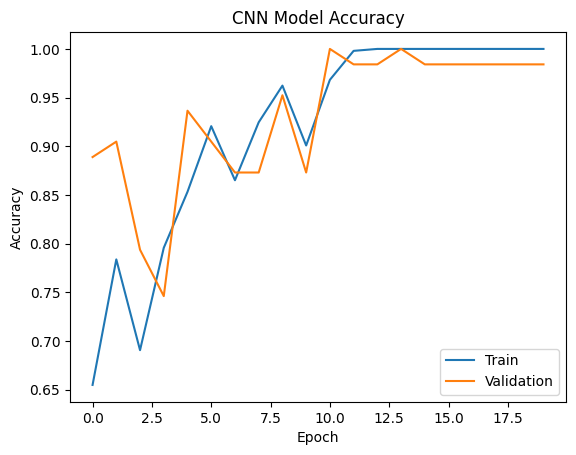

In [19]:
# Plotting the Accuracy values across epochs for training and validation dataset calculated above
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

**Observation**: The Model accuracy graphs seem to flatten after 15 epochs and the training and validation accuracy levels seem similar. So we don't see much overfitting of the model.

In [84]:
# Displaying the model training performance
cnn_model_train_perf = model_performance_classification(cnn_model, X_train_normalized, y_train)
print("Train Performance using CNN:")
print(cnn_model_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Train Performance using CNN:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


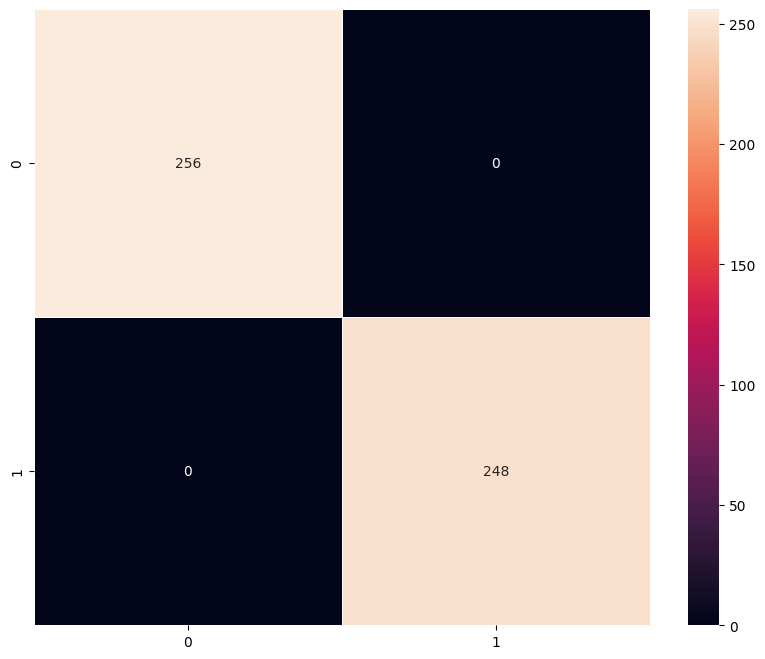

In [26]:
# Plotting the Confusion matrix to look at the training performance - Actual vs predicted labels
plot_confusion_matrix(cnn_model, X_train_normalized, y_train)

In [85]:
# Displaying the model validation performance
cnn_model_val_perf = model_performance_classification(cnn_model, X_val_normalized, y_val)
print("Validation Performance using CNN:")
print(cnn_model_val_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Validation Performance using CNN:
   Accuracy    Recall  Precision  F1 Score
0    0.9841  0.984127   0.984608  0.984119


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


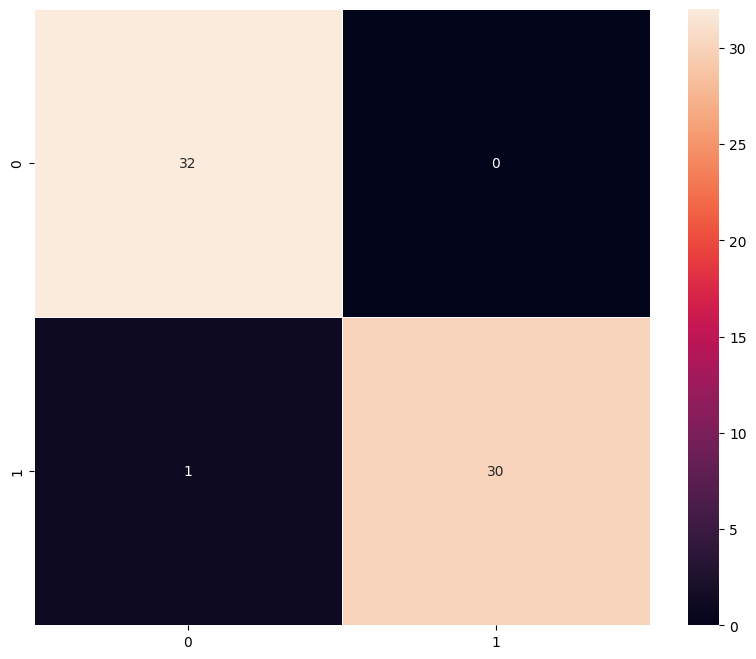

In [28]:
# Plotting the Confusion matrix to look at the validation performance - Actual vs predicted labels
plot_confusion_matrix(cnn_model, X_val_normalized, y_val)

**Observation**: The Training accuracy is 100% while the validation accuracy is more than 98%. **The model is classifying only 1 of 63 images incorrectly from the validation set.** Hence, this is a very good model.

### Vizualizing the predictions

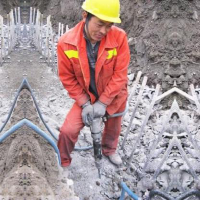

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Label: 1 - With Helmet
True Label: Label    1
Name: 115, dtype: int64


In [41]:
ind = 50                  # To choose a random index value between 0 to 62 to choose image from validation set
cv2_imshow(X_val[ind])    # Displaying the selected image from Validation set
cnn_prediction = cnn_model.predict(X_val_normalized[ind].reshape(1,200,200,3))    # Predicting the label using cnn_model
if cnn_prediction[0][0]>0.5:
  print('Predicted Label: 1 - With Helmet')       # Assigning a condition of if predicted value of y is > 0.5 it is to be read as 1 which is Image has helmet
else:
  print('Predicted Label: 0 - Without Helmet')    # Assigning a condition of if predicted value of y is <= 0.5 it is to be read as 0 which is No helmet
actual = y_val.iloc[ind]
print('True Label:', actual)                      # Printing the Actual / Original label of the picture to compare with Predicted label

**Observation**: Here we are looking at a sample of the simple CNN model prediction. As we can see the predicted label and True label are both 1 i.e., With Helmet (as evident in the picture) which signifies that the model is predicting accurately.

Similarly we can test predictions for other images by changing the 'ind' value which is 50 here.

## Model 2: (VGG-16 (Base))

In [30]:
# Loading the VGG-16 model
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))   # Weights pre-trained on the ImageNet dataset, include top is False as we want to add our own input and output layer
vgg.summary()              # Printing the summary of the model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**Observation**: The VGG-16 model has been loaded which will be used in the current and next 2 models.

In [31]:
# Freezing the weights of the VGG-16 layer as we dont want to train them
for layer in vgg.layers:
    layer.trainable = False

In [32]:
# Creating a CNN using VGG-16 model
vgg_model = Sequential()                                                                               # Initializing the model as a Sequential model
vgg_model.add(vgg)                                                                                     # Adding the VGG-16 model
vgg_model.add(Flatten())                                                                               # Flattening the output of the previous layer to be fed to the NN as input
vgg_model.add(Dense(1, activation='sigmoid'))                                                          # Adding the output layer with 1 neuron as this is binary classification and sigmoid activation layer
opt = Adam(learning_rate=0.01)                                                                         # Defining the Optimizer and learning rate
vgg_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])                     # Configuring the model for training
vgg_model.summary()                                                                                    # Printing the summary of the model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [33]:
train_datagen = ImageDataGenerator()  # Handles loading image data in batches

In [34]:
batch_size = 16              # Number of images in each batch
history_vgg = vgg_model.fit(train_datagen.flow(X_train_normalized, y_train, batch_size=batch_size, seed = 42), # Fitting the model created above with the dependent and independent variables to train the model
                            epochs=15,                                                                      # Number of times the model will iterate over the training dataset
                            steps_per_epoch= X_train_normalized.shape[0] // batch_size,                     # Number of batches to be processed per epoch
                            validation_data=(X_val_normalized, y_val),                                      # Defining the validation data
                            verbose=2,                                                                      # Shows the results from each epoch
                            shuffle=False)                                                                  # Shuffles the training data before each epoch so that model doesnot learn the order of training data

Epoch 1/15
31/31 - 52s - 2s/step - accuracy: 0.9355 - loss: 0.2353 - val_accuracy: 1.0000 - val_loss: 1.1472e-08
Epoch 2/15
31/31 - 5s - 170ms/step - accuracy: 1.0000 - loss: 4.2596e-12 - val_accuracy: 1.0000 - val_loss: 3.7795e-08
Epoch 3/15
31/31 - 27s - 883ms/step - accuracy: 0.9960 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 2.3485e-14
Epoch 4/15
31/31 - 0s - 12ms/step - accuracy: 1.0000 - loss: 5.4952e-10 - val_accuracy: 1.0000 - val_loss: 1.9891e-14
Epoch 5/15
31/31 - 5s - 155ms/step - accuracy: 1.0000 - loss: 8.7354e-04 - val_accuracy: 1.0000 - val_loss: 1.8962e-13
Epoch 6/15
31/31 - 0s - 12ms/step - accuracy: 1.0000 - loss: 2.1684e-16 - val_accuracy: 1.0000 - val_loss: 1.8020e-13
Epoch 7/15
31/31 - 2s - 71ms/step - accuracy: 1.0000 - loss: 1.4205e-07 - val_accuracy: 1.0000 - val_loss: 1.1372e-13
Epoch 8/15
31/31 - 0s - 13ms/step - accuracy: 1.0000 - loss: 8.3353e-15 - val_accuracy: 1.0000 - val_loss: 1.1349e-13
Epoch 9/15
31/31 - 5s - 151ms/step - accuracy: 1.0000 - loss:

**Observation**: Using the VGG-16 model we have reduced the trainable parameters drastically as we are not training weights from convolution layers. We have added a layer to flatten the results from VGG-16 and added an output layer to display the results using a sigmoid activation function.

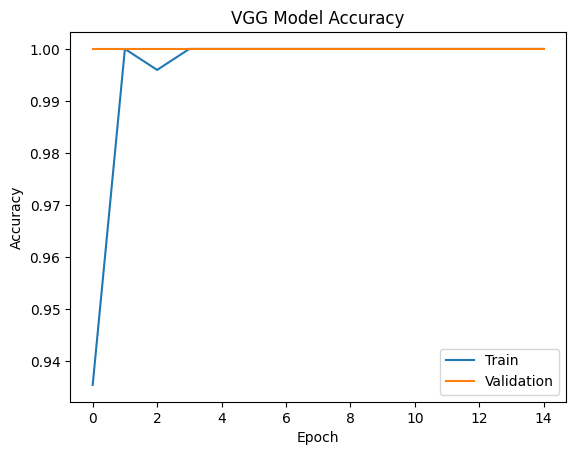

In [35]:
# Plotting the Accuracy values across epochs for training and validation dataset calculated above
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('VGG Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

**Observation**: The Training and Validation Accuracy are flat and same after 3 epochs.

In [86]:
# Displaying the model training performance
vgg_model_train_perf = model_performance_classification(vgg_model, X_train_normalized, y_train)
print("Train Performance using VGG-16 base:")
print(vgg_model_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step
Train Performance using VGG-16 base:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step


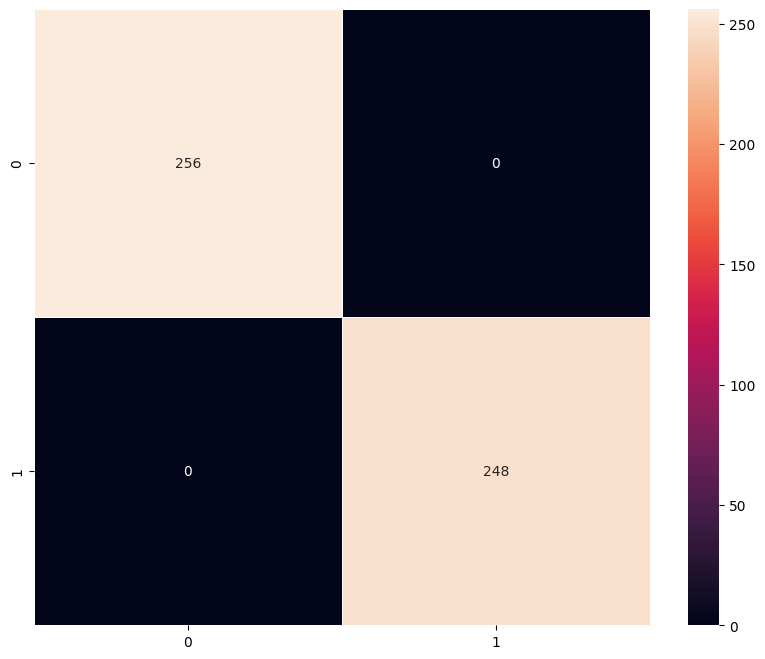

In [37]:
# Plotting the Confusion matrix to look at the training performance - Actual vs predicted labels
plot_confusion_matrix(vgg_model, X_train_normalized, y_train)

In [87]:
# Displaying the model validation performance
vgg_model_val_perf = model_performance_classification(vgg_model, X_val_normalized, y_val)
print("Validation Performance using VGG-16 base:")
print(vgg_model_val_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Validation Performance using VGG-16 base:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


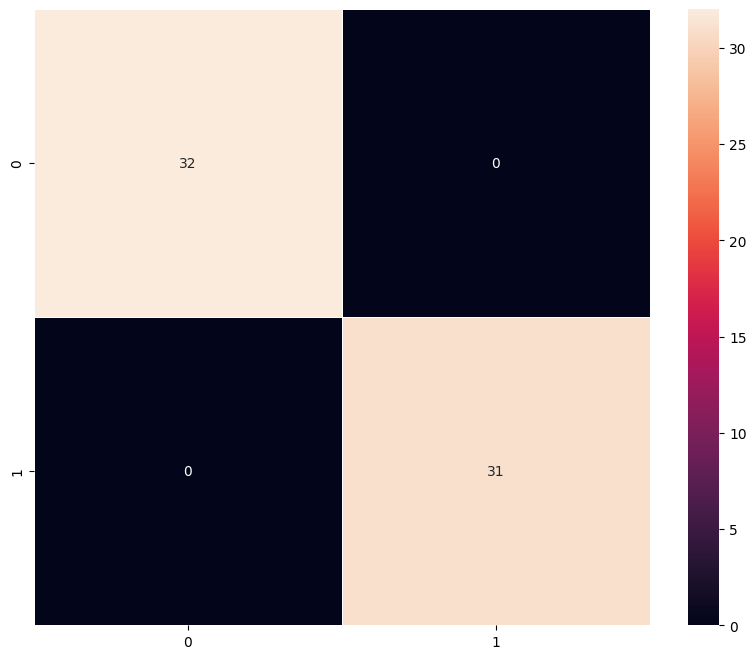

In [39]:
# Plotting the Confusion matrix to look at the validation performance - Actual vs predicted labels
plot_confusion_matrix(vgg_model, X_val_normalized, y_val)

**Observation**: The Training and Validation accuracy are 100%. The model is classifying all of the 63 images correctly from the validation set and is genaralizing very well. Hence, this is a great model for us to use.

### Visualizing the prediction:

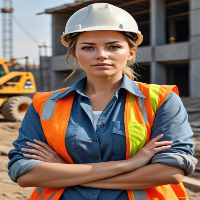

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label: 1 - With Helmet
True Label: Label    1
Name: 91, dtype: int64


In [40]:
ind = 46                  # To choose a random index value between 1 to 62 to choose image from validation set
cv2_imshow(X_val[ind])    # Displaying the selected image from Validation set
vgg_prediction = vgg_model.predict(X_val_normalized[ind].reshape(1,200,200,3))    # Predicting the label using vgg_model
if vgg_prediction[0][0]>0.5:
  print('Predicted Label: 1 - With Helmet')       # Assigning a condition of if predicted value of y is > 0.5 it is to be read as 1 which is Image has helmet
else:
  print('Predicted Label: 0 - Without Helmet')    # Assigning a condition of if predicted value of y is <= 0.5 it is to be read as 0 which is No helmet
actual = y_val.iloc[ind]
print('True Label:', actual)                      # Printing the Actual / Original label of the picture to compare with Predicted label

**Observation**: Here we are looking at a sample of the VGG-16 base model prediction. As we can see the predicted label and True label are both 1 i.e., With Helmet (as evident in the picture) which signifies that the model is predicting accurately.

Similarly we can test predictions for other images by changing the 'ind' value which is 46 here.

## Model 3: (VGG-16 (Base + FFNN))

Here we are adding a Feed Forward Neural network (FFNN) to the VGG-16 model.

In [42]:
# Creating a CNN using VGG-16 + FFNN model
vgg_ffnn_model = Sequential()                                                                               # Initializing the model as a Sequential model
vgg_ffnn_model.add(vgg)                                                                                     # Adding the VGG-16 model
vgg_ffnn_model.add(Flatten())                                                                               # Flattening the output of the previous layer to be fed to the NN as input

# Adding the feed forward neural network
vgg_ffnn_model.add(Dense(32, activation='relu'))                                                            # Adding a Dense hidden layer with 32 neurons and relu activation layer
vgg_ffnn_model.add(Dropout(0.4))                                                                            # Adding a Dropout layer to prevent overfitting
vgg_ffnn_model.add(Dense(16, activation='relu'))                                                            # Adding a Dense hidden layer with 16 neurons and relu activation layer

vgg_ffnn_model.add(Dense(1, activation='sigmoid'))                                                          # Adding the output layer with 1 neuron as this is binary classification and sigmoid activation layer
opt = Adam(learning_rate=0.01)                                                                              # Defining the Optimizer and learning rate
vgg_ffnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])                     # Configuring the model for training
vgg_ffnn_model.summary()                                                                                    # Printing the summary of the model

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,305,089 (58.38 MB)

 Trainable params: 590,401 (2.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [43]:
batch_size_ffnn = 16              # Number of images in each batch
history_vgg_ffnn = vgg_ffnn_model.fit(train_datagen.flow(X_train_normalized, y_train, batch_size=batch_size_ffnn, seed = 42), # Fitting the model created above with the dependent and independent variables to train the model
                            epochs=15,                                                                              # Number of times the model will iterate over the training dataset
                            steps_per_epoch= X_train_normalized.shape[0] // batch_size_ffnn,                        # Number of batches to be processed per epoch
                            validation_data=(X_val_normalized, y_val),                                              # Defining the validation data
                            verbose=2,                                                                              # Shows the results from each epoch
                            shuffle=False)                                                                          # Shuffles the training data before each epoch so that model doesnot learn the order of training data

Epoch 1/15
31/31 - 6s - 208ms/step - accuracy: 0.9153 - loss: 0.4316 - val_accuracy: 1.0000 - val_loss: 4.4276e-06
Epoch 2/15
31/31 - 2s - 56ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 5.2884e-06
Epoch 3/15
31/31 - 6s - 185ms/step - accuracy: 0.9819 - loss: 0.0578 - val_accuracy: 1.0000 - val_loss: 2.9617e-04
Epoch 4/15
31/31 - 0s - 10ms/step - accuracy: 1.0000 - loss: 3.3267e-04 - val_accuracy: 1.0000 - val_loss: 3.2911e-04
Epoch 5/15
31/31 - 2s - 73ms/step - accuracy: 0.9859 - loss: 0.0611 - val_accuracy: 1.0000 - val_loss: 1.4573e-07
Epoch 6/15
31/31 - 0s - 10ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 1.3207e-07
Epoch 7/15
31/31 - 5s - 162ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 1.4110e-07
Epoch 8/15
31/31 - 1s - 24ms/step - accuracy: 1.0000 - loss: 8.4881e-05 - val_accuracy: 1.0000 - val_loss: 1.5312e-07
Epoch 9/15
31/31 - 4s - 132ms/step - accuracy: 0.9940 - loss: 0.0562 - val_ac

**Observation**: Using the VGG-16 model and adding a feed forward network we have increased the trainable parameters slightly from previous model as we added 2 hidden layers. Like the previous model we have a layer to flatten the results from VGG-16 and an output layer to display the results using a sigmoid activation function.

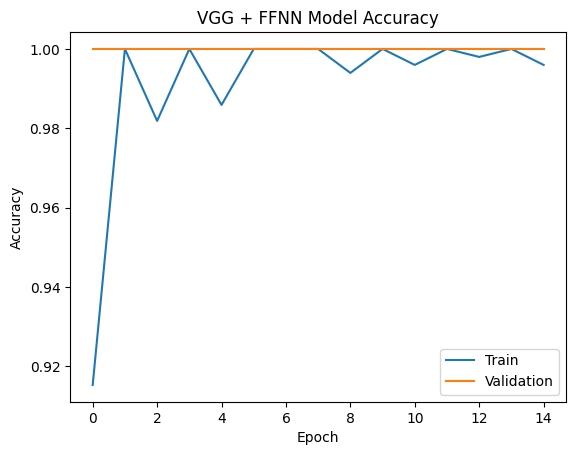

In [44]:
# Plotting the Accuracy values across epochs for training and validation dataset calculated above
plt.plot(history_vgg_ffnn.history['accuracy'])
plt.plot(history_vgg_ffnn.history['val_accuracy'])
plt.title('VGG + FFNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

**Observation**: The Training Accuracy is almost flat varying between 99.5% to 100% after the 6th epoch and Validation Accuracy is flat throughout displaying 100% Accuracy.

In [88]:
# Displaying the model training performance
vgg_ffnn_model_train_perf = model_performance_classification(vgg_ffnn_model, X_train_normalized, y_train)
print("Train Performance using VGG-16 base + FFNN:")
print(vgg_ffnn_model_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step
Train Performance using VGG-16 base + FFNN:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step


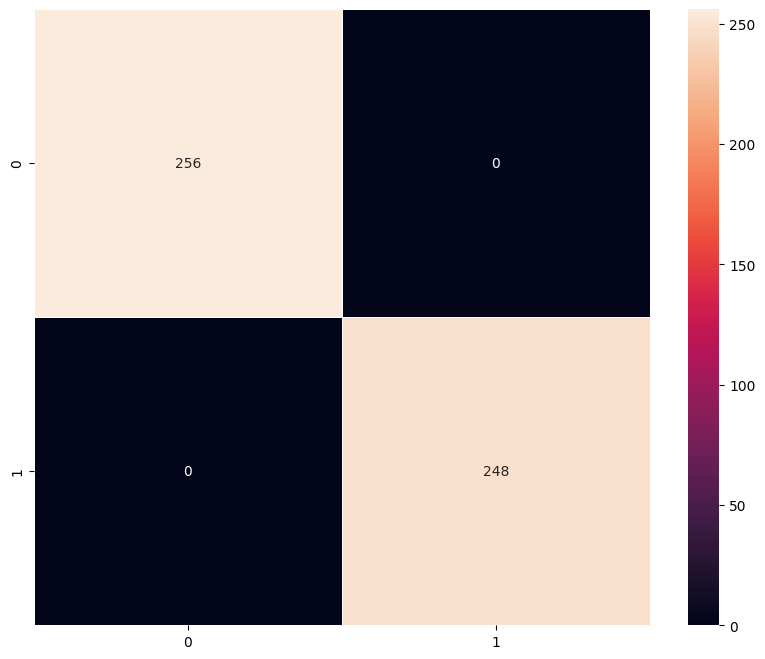

In [46]:
# Plotting the Confusion matrix to look at the training performance - Actual vs predicted labels
plot_confusion_matrix(vgg_ffnn_model, X_train_normalized, y_train)

In [89]:
# Displaying the model validation performance
vgg_ffnn_model_val_perf = model_performance_classification(vgg_ffnn_model, X_val_normalized, y_val)
print("Validation Performance using VGG-16 base + FFNN:")
print(vgg_ffnn_model_val_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Validation Performance using VGG-16 base + FFNN:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


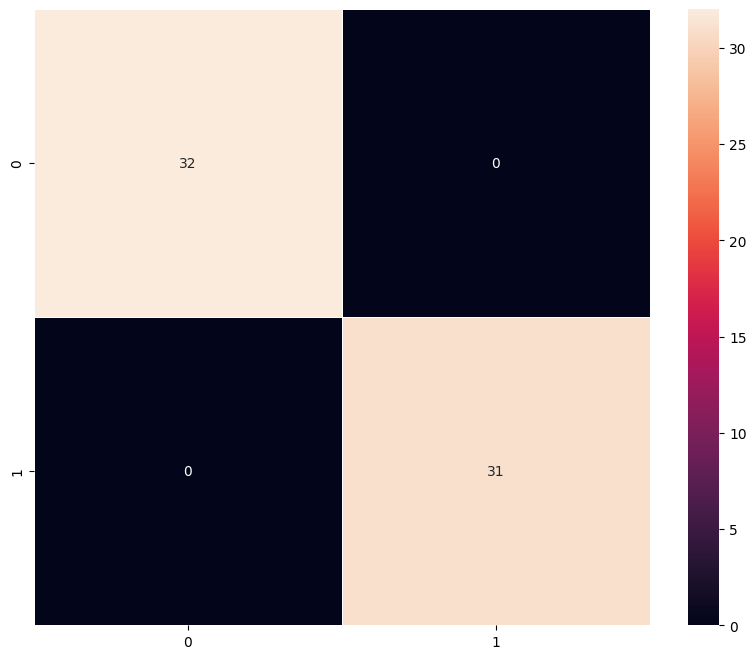

In [48]:
# Plotting the Confusion matrix to look at the validation performance - Actual vs predicted labels
plot_confusion_matrix(vgg_ffnn_model, X_val_normalized, y_val)

**Observation**: The Training and Validation accuracy are almost 100%. The model is classifying all of the 63 images correctly from the validation set and is genaralizing very well. Hence, this model like the previous one is also a great model for us to use.

#### Visualizing the predictions

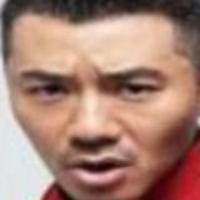

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Label: 0 - Without Helmet
True Label: Label    0
Name: 358, dtype: int64


In [90]:
ind = 52                  # To choose a random index value between 1 to 62 to choose image from validation set
cv2_imshow(X_val[ind])    # Displaying the selected image from Validation set
vgg_ffnn_prediction = vgg_ffnn_model.predict(X_val_normalized[ind].reshape(1,200,200,3))    # Predicting the label using vgg_ffnn_model
if vgg_ffnn_prediction[0][0]>0.5:
  print('Predicted Label: 1 - With Helmet')       # Assigning a condition of if predicted value of y is > 0.5 it is to be read as 1 which is Image has helmet
else:
  print('Predicted Label: 0 - Without Helmet')    # Assigning a condition of if predicted value of y is <= 0.5 it is to be read as 0 which is No helmet
actual = y_val.iloc[ind]
print('True Label:', actual)                      # Printing the Actual / Original label of the picture to compare with Predicted label


**Observation**: Here we are looking at a sample of the VGG-16 + FFNN model prediction. As we can see the predicted label and True label are both 0 i.e., Without Helmet (as evident in the picture) which signifies that the model is predicting accurately.

Similarly we can test predictions for other images by changing the 'ind' value which is 52 here.

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

Here we are doing Data Augmentation in addition to adding a Feed Forward Neural network (FFNN) to the VGG-16 model.

In [67]:
# Creating a CNN using VGG-16 + FFNN model
vgg_ffnn_da_model = Sequential()                                                                               # Initializing the model as a Sequential model
vgg_ffnn_da_model.add(vgg)                                                                                     # Adding the VGG-16 model
vgg_ffnn_da_model.add(Flatten())                                                                               # Flattening the output of the previous layer to be fed to the NN as input

# Adding the feed forward neural network
vgg_ffnn_da_model.add(Dense(32, activation='relu'))                                                            # Adding a Dense hidden layer with 32 neurons and relu activation layer
vgg_ffnn_da_model.add(Dropout(0.5))                                                                            # Adding a Dropout layer to prevent overfitting
vgg_ffnn_da_model.add(Dense(16, activation='relu'))                                                            # Adding a Dense hidden layer with 16 neurons and relu activation layer

vgg_ffnn_da_model.add(Dense(1, activation='sigmoid'))                                                          # Adding the output layer with 1 neuron as this is binary classification and sigmoid activation layer
opt = Adam(learning_rate=0.001)                                                                                 # Defining the Optimizer and learning rate
vgg_ffnn_da_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])                     # Configuring the model for training
vgg_ffnn_da_model.summary()                                                                                    # Printing the summary of the model

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,305,089 (58.38 MB)

 Trainable params: 590,401 (2.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [68]:
# Data Augmentation
train_datagen = ImageDataGenerator(             # Initializes Data Augmentation Techniques and Handles loading image data in batches
    horizontal_flip=True,                       # Horizontally flipped images to be included
    vertical_flip=True,                         # Vertically flipped images to be included
    height_shift_range=0.2,                     # Images with Height increased by upto 20% included
    width_shift_range=0.2,                      # Images with Width increased by upto 20% included
    rotation_range=45,                          # Images rotated by upto 45 degrees included
    shear_range=0.2,                            # Applies random shearing transformations
    zoom_range=0.2                              # Zoomed images by upto 20% included
)

In [69]:
batch_size_ffnn_da = 16              # Number of images in each batch
history_vgg_ffnn_da = vgg_ffnn_da_model.fit(train_datagen.flow(X_train_normalized, y_train, batch_size=batch_size_ffnn_da, seed = 42), # Fitting the model created above with the dependent and independent variables to train the model
                            epochs=15,                                                                              # Number of times the model will iterate over the training dataset
                            steps_per_epoch= X_train_normalized.shape[0] // batch_size_ffnn_da,                     # Number of batches to be processed per epoch
                            validation_data=(X_val_normalized, y_val),                                              # Defining the validation data
                            verbose=2,                                                                              # Shows the results from each epoch
                            shuffle=False)                                                                          # Shuffles the training data before each epoch so that model doesnot learn the order of training data

Epoch 1/15
31/31 - 10s - 322ms/step - accuracy: 0.8810 - loss: 0.2514 - val_accuracy: 1.0000 - val_loss: 0.0096
Epoch 2/15
31/31 - 2s - 52ms/step - accuracy: 0.8750 - loss: 0.1015 - val_accuracy: 1.0000 - val_loss: 0.0105
Epoch 3/15
31/31 - 5s - 177ms/step - accuracy: 0.9778 - loss: 0.0773 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 4/15
31/31 - 0s - 12ms/step - accuracy: 1.0000 - loss: 0.0370 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 5/15
31/31 - 5s - 150ms/step - accuracy: 0.9839 - loss: 0.0460 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 6/15
31/31 - 0s - 12ms/step - accuracy: 1.0000 - loss: 0.0191 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 7/15
31/31 - 5s - 148ms/step - accuracy: 0.9819 - loss: 0.0462 - val_accuracy: 1.0000 - val_loss: 4.2436e-04
Epoch 8/15
31/31 - 0s - 12ms/step - accuracy: 0.8750 - loss: 0.6009 - val_accuracy: 1.0000 - val_loss: 4.0370e-04
Epoch 9/15
31/31 - 6s - 188ms/step - accuracy: 0.9758 - loss: 0.0540 - val_accuracy: 1.0000 - val_loss: 0.0

**Observation**: Using the VGG-16 model, Adding a feed forward network and doing Data Augmentation, our trainable parameters are same as the previous model as Data Augmentation doesn't add any new weights. Like the previous model we have a layer to flatten the results from VGG-16 and an output layer to display the results using a sigmoid activation function.

Only difference is we are adding images derived from original images for training the data by slight changes to them like Horizontal or Vertical flip, Image rotation by some degrees, Zoom by certain percentage so that model is robust to small changes.

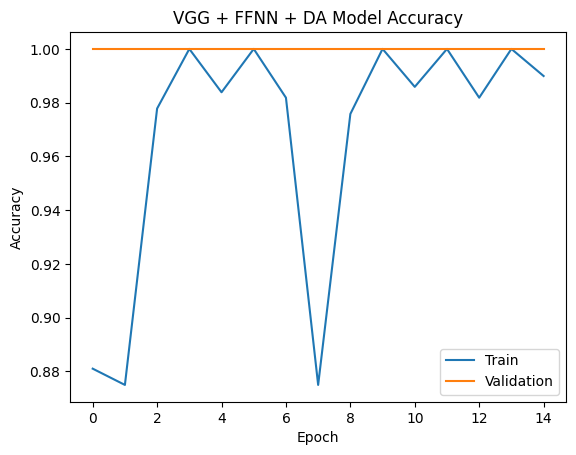

In [70]:
# Plotting the Accuracy values across epochs for training and validation dataset calculated above
plt.plot(history_vgg_ffnn_da.history['accuracy'])
plt.plot(history_vgg_ffnn_da.history['val_accuracy'])
plt.title('VGG + FFNN + DA Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

**Observation**: The Training Accuracy is mostly varying between 98% to 100% after the 8th epoch and Validation Accuracy is flat throughout displaying 100% Accuracy.

In [91]:
# Displaying the model training performance
vgg_ffnn_da_model_train_perf = model_performance_classification(vgg_ffnn_da_model, X_train_normalized, y_train)
print("Train Performance using VGG-16 base + FFNN + Data Augmentation:")
print(vgg_ffnn_da_model_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step
Train Performance using VGG-16 base + FFNN + Data Augmentation:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step


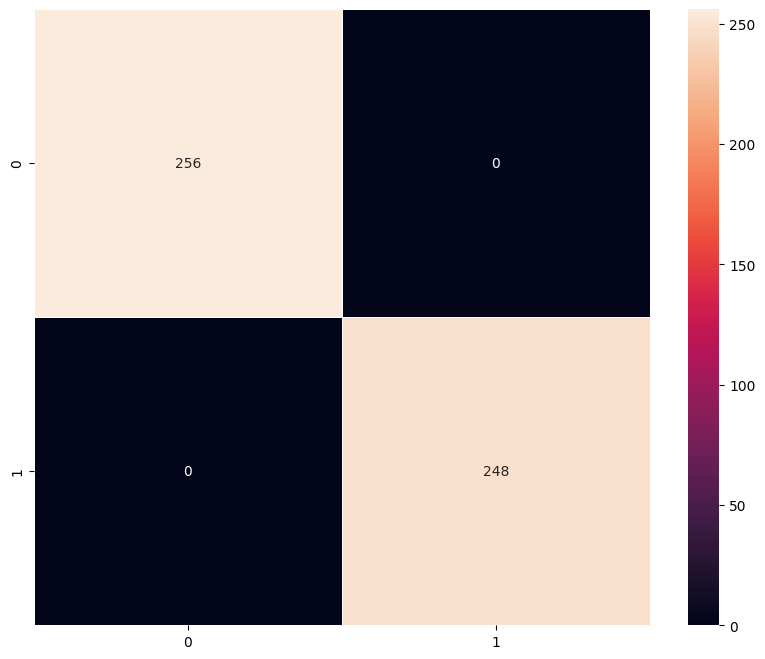

In [72]:
# Plotting the Confusion matrix to look at the training performance - Actual vs predicted labels
plot_confusion_matrix(vgg_ffnn_da_model, X_train_normalized, y_train)

In [92]:
# Displaying the model validation performance
vgg_ffnn_da_model_val_perf = model_performance_classification(vgg_ffnn_da_model, X_val_normalized, y_val)
print("Validation Performance using VGG-16 base + FFNN + Data Augmentation:")
print(vgg_ffnn_da_model_val_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Validation Performance using VGG-16 base + FFNN + Data Augmentation:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


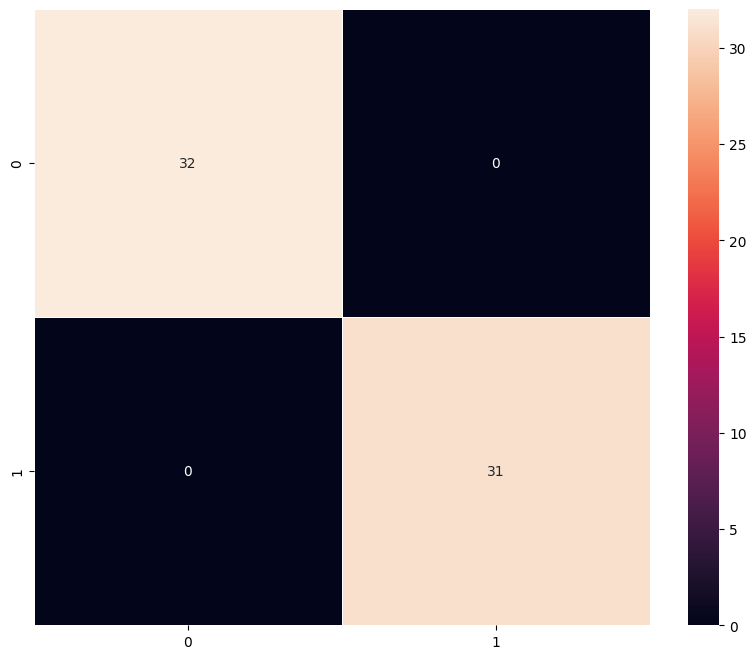

In [74]:
# Plotting the Confusion matrix to look at the validation performance - Actual vs predicted labels
plot_confusion_matrix(vgg_ffnn_da_model, X_val_normalized, y_val)

**Observation**: The Training and Validation accuracy are almost 100%. The model is classifying all of the 63 images correctly from the validation set and is genaralizing very well. Hence, this model like the previous 2 models is also a great model for us to use.

#### Visualizing the predictions

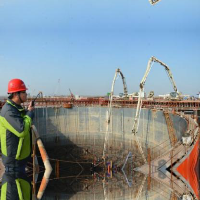

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Predicted Label: 1 - With Helmet
True Label: Label    1
Name: 35, dtype: int64


In [75]:
ind = 9                   # To choose a random index value between 1 to 62 to choose image from validation set
cv2_imshow(X_val[ind])    # Displaying the selected image from Validation set
vgg_ffnn_da_prediction = vgg_ffnn_da_model.predict(X_val_normalized[ind].reshape(1,200,200,3))    # Predicting the label using vgg_ffnn_da_model
if vgg_ffnn_da_prediction[0][0]>0.5:
  print('Predicted Label: 1 - With Helmet')       # Assigning a condition of if predicted value of y is > 0.5 it is to be read as 1 which is Image has helmet
else:
  print('Predicted Label: 0 - Without Helmet')    # Assigning a condition of if predicted value of y is <= 0.5 it is to be read as 0 which is No helmet
actual = y_val.iloc[ind]
print('True Label:', actual)                      # Printing the Actual / Original label of the picture to compare with Predicted label

**Observation**: Here we are looking at a sample of the VGG-16 + FFNN + Data Augmentation model prediction. As we can see the predicted label and True label are both 1 i.e., With Helmet (as evident in the picture) which signifies that the model is predicting accurately.

Similarly we can test predictions for other images by changing the 'ind' value which is 9 here.

# **Model Performance Comparison and Final Model Selection**

In [93]:
# Model Performance comparision - Creating a dataframe to combine all the scores obtained for different models on training dataset
models_comp_train_df = pd.concat(
                          [cnn_model_train_perf.T,
                           vgg_model_train_perf.T,
                           vgg_ffnn_model_train_perf.T,
                           vgg_ffnn_da_model_train_perf.T],
                          axis=1)
models_comp_train_df.columns = ['CNN', 'VGG-16', 'VGG-16 + FFNN', 'VGG-16 + FFNN + Data Augmentation']
print(models_comp_train_df)

           CNN  VGG-16  VGG-16 + FFNN  VGG-16 + FFNN + Data Augmentation
Accuracy   1.0     1.0            1.0                                1.0
Recall     1.0     1.0            1.0                                1.0
Precision  1.0     1.0            1.0                                1.0
F1 Score   1.0     1.0            1.0                                1.0


In [94]:
# Model Performance comparision - Creating a dataframe to combine all the scores obtained for different models on validation dataset
models_comp_val_df = pd.concat(
                          [cnn_model_val_perf.T,
                           vgg_model_val_perf.T,
                           vgg_ffnn_model_val_perf.T,
                           vgg_ffnn_da_model_val_perf.T],
                          axis=1)
models_comp_val_df.columns = ['CNN', 'VGG-16', 'VGG-16 + FFNN', 'VGG-16 + FFNN + Data Augmentation']
print(models_comp_val_df)

                CNN  VGG-16  VGG-16 + FFNN  VGG-16 + FFNN + Data Augmentation
Accuracy   0.984100     1.0            1.0                                1.0
Recall     0.984127     1.0            1.0                                1.0
Precision  0.984608     1.0            1.0                                1.0
F1 Score   0.984119     1.0            1.0                                1.0


In [78]:
# Evaluating the difference between performance scores of training and validation data using different models to evaluate model generalization
models_comp_train_df - models_comp_val_df

,CNN,VGG-16,VGG-16 + FFNN,VGG-16 + FFNN + Data Augmentation
Accuracy,0.015873,0.0,0.0,0.0
Recall,0.015873,0.0,0.0,0.0
Precision,0.015392,0.0,0.0,0.0
F1 Score,0.015881,0.0,0.0,0.0


**Observation**: As we can see from above results, all the models are giving excellent results especially using the VGG-16 model.

Based on the above results the model **we are selecting is VGG-16 + FFNN + Data Augmentation model** as it has **100% Accuracy for both Training and Validation data**. Also, the model **would be more Robust and enhance generalization due to Data Augmentation**.

## Test Performance

In [81]:
# Evaluating the performance of the selected VGG-16 + FFNN + Data Augmentation model using unseen test data
model_test_perf = model_performance_classification(vgg_ffnn_da_model, X_test_normalized, y_test)
print("Test Performance using VGG-16 base + FFNN + Data Augmentation:")
print(model_test_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Test Performance using VGG-16 base + FFNN + Data Augmentation:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


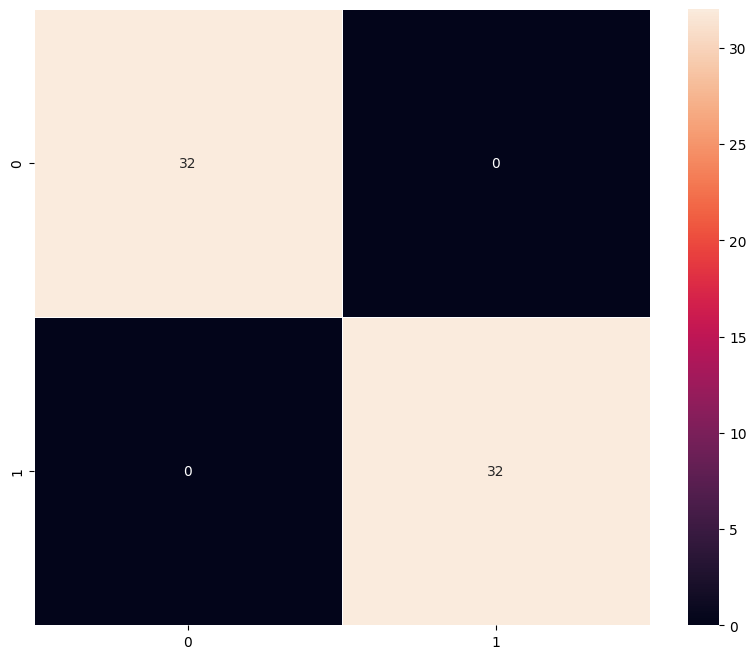

In [82]:
# Plotting the Confusion matrix to look at the Test data performance - Actual vs predicted labels
plot_confusion_matrix(vgg_ffnn_da_model, X_test_normalized, y_test)

**Observation**: As we can see from above results, the selected **VGG-16 + FFNN + Data Augmentation model is doing great** in predicting the labels for the Images in the **unseen test dataset with 100% Accuracy.**

# **Actionable Insights & Recommendations**

- All the models gave excellent results with Validation Accuracy above 98% for all, which means there are clear patterns being detected in the Images in the dataset using CNN.
- Adding the VGG-16 model with the pre-trained weights not only reduced the trainable parameters but made the models more efficient giving 100% Accuracy.
- The VGG-16 + FFNN + Data Augmentation model was selected as the model would be more robust when predicting labels for new unseen images as it has been trained on more variations of the original images with Data Augmentation.
- The models did not overfit as Accuracy results for both Training and Validation set was very similar to each other for all of them.


- The dataset with which the model was trained was very small. The models can be retrained using larger dataset when it is available to make the new model more robust.
- Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance in future when there is a larger dataset.
- Other Transfer Learning architectures can be used instead of VGG-16 which would suit the context of Safety even better.
- Different number of filters and filter sizes can also be used to train the CNN model to provide better results when using a larger image sample.


<font size=5 color='blue'>Power Ahead!</font>
___

In [98]:
!jupyter nbconvert --to html '/content/HelmNet_Full_Code.ipynb'

[NbConvertApp] Converting notebook /content/HelmNet_Full_Code.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 21 image(s).
[NbConvertApp] Writing 2130715 bytes to /content/HelmNet_Full_Code.html
